IMPORTING THE LIBRARIES

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, LSTM, SimpleRNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import pathlib


IMPORTING THE DATASET

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab/dataset', image_size=(64, 64), batch_size=32
)

print(type(dataset))

Found 2515 files belonging to 36 classes.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


this  is a multiclass dataset

SPLITTING THE DATASET

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
import os
path = '/content/drive/MyDrive/Colab/dataset'
print(os.listdir(path))

['w', 'k', 'e', '5', '3', '2', 'y', 'p', 'l', 'b', 'x', '4', 'q', 'v', 'j', 'd', 'c', 'f', 'a', 's', 'm', 'o', 'h', 't', '8', '0', 'i', '9', '6', 'n', 'z', '7', 'g', '1', 'u', 'r']


In [ ]:
# splitfolders.ratio(path,seed=42, output="data-Splitted", ratio=(0.8, 0.2))

DATA PREPROCESSING

Loading & Applying Augmentation on Training set

Normalization- The images are stored with pixel values ranging from 0 to 255. So, value 255 is used to normalize pixel values to be between 0 and 1

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range= 0.2,
    horizontal_flip = True)

training_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab/data-Splitted/train',
    target_size =(64,64),
    batch_size = 32,
    class_mode = 'categorical',
    seed=42,
    shuffle=False)


Found 2012 images belonging to 36 classes.


Loading the Test set

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1./255)
test_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab/data-Splitted/test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    seed=42,
    shuffle=False
)


Found 503 images belonging to 36 classes.


**Get the Label Mappings**


In [ ]:
# Getting the class indices from the training_set
class_indices = training_set.class_indices

# Creating a list of class labels
labels = list(class_indices.keys())

# Print the list of class labels
print("List of class labels for classes present in the training and validation datasets\n")
for label in labels:
    print(label)


List of class labels for classes present in the training and validation datasets

0
1
2
3
4
5
6
7
8
9
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z


In [ ]:
print(len(labels))


36


In [ ]:
print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


**Plotting** **Sample Training Images** **bold text**

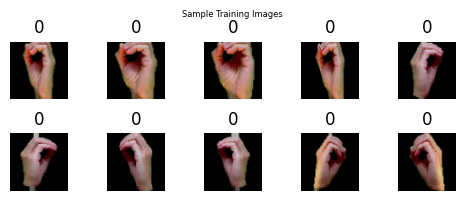

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(5, 2))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(training_set[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(training_set[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=6)
plt.show()

**DONT RUN THE CODE BELOW**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, SimpleRNN
from keras.layers import TimeDistributed, Conv2D, Flatten, SimpleRNN, Dense
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import History
import matplotlib.pyplot as plt
import pickle

num_classes = 36
sequence_length = 10
input_features= 64 * 64 * 3

# Is used to reduce the learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)


##### Model 1
model_cnn = None
history1 = History()

def model_one():
  global model_cnn
  global history1

  model_cnn = Sequential()
  model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
  model_cnn.add(MaxPooling2D((2, 2)))
  model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
  model_cnn.add(MaxPooling2D((2, 2)))
  model_cnn.add(Flatten())
  model_cnn.add(Dense(128, activation='relu'))
  model_cnn.add(Dense(num_classes, activation='softmax'))

  model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Clear history before each training
  history1 = History()

  model_cnn.fit(training_set, epochs=78, validation_data=test_set, verbose=2, callbacks=[reduce_lr, history1])

  # Save the model and history
  model_cnn.save('/content/drive/MyDrive/Colab/Models/model_cnn.h5')
  with open('/content/drive/MyDrive/Colab/Historys/history1.pkl', 'wb') as f:
      pickle.dump(history1.history, f)

  return model_cnn.evaluate(test_set)

##### Model 2
model_rnn = None
history2 = History()

def model_two():
  global model_rnn
  global history2

  def create_sequences(data_generator, sequence_length):
      sequences = []
      labels = []

      for _ in range(len(data_generator)):
          batch, label = next(data_generator)
          sequences.append(batch)
          labels.append(label)

      sequences = np.vstack(sequences)
      labels = np.vstack(labels)

      return sequences, labels

  train_sequences, train_labels = create_sequences(training_set, sequence_length)
  test_sequences, test_labels = create_sequences(test_set, sequence_length)

  # Ensure labels are one-hot encoded
  train_labels_one_hot = tf.keras.utils.to_categorical(train_labels.argmax(axis=1), num_classes=num_classes)
  test_labels_one_hot = tf.keras.utils.to_categorical(test_labels.argmax(axis=1), num_classes=num_classes)

  # Define the CNN model to extract features from each image
  def create_cnn():
      model = Sequential()
      model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
      model.add(Flatten())
      return model

  # Create a CNN model
  cnn_model = create_cnn()

  # Use TimeDistributed to apply the CNN model to each time step
  model_rnn = Sequential()
  model_rnn.add(TimeDistributed(cnn_model, input_shape=(sequence_length, 64, 64, 3)))
  model_rnn.add(SimpleRNN(64, activation='relu'))
  model_rnn.add(Dense(num_classes, activation='softmax'))

  model_rnn.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Calculate the number of batches
  num_batches = min(len(training_set), len(test_set))

  # Reshape sequences to match the input shape expected by SimpleRNN
  train_samples, _, _, _ = train_sequences.shape
  test_samples, _, _, _ = test_sequences.shape

  # Calculate the maximum number of sequences that can be extracted
  max_train_sequences = (train_samples // sequence_length) * sequence_length
  max_test_sequences = (test_samples // sequence_length) * sequence_length

  # Reshape the sequences and adjust labels accordingly
  train_sequences_reshaped = train_sequences[:max_train_sequences].reshape((-1, sequence_length, 64, 64, 3))
  test_sequences_reshaped = test_sequences[:max_test_sequences].reshape((-1, sequence_length, 64, 64, 3))

  # Calculate the number of sequences
  num_train_sequences = train_sequences_reshaped.shape[0]
  num_test_sequences = test_sequences_reshaped.shape[0]

  # Adjust labels to match the number of sequences
  train_labels_adjusted = train_labels_one_hot[:num_train_sequences * sequence_length:sequence_length]
  test_labels_adjusted = test_labels_one_hot[:num_test_sequences * sequence_length:sequence_length]

  # Clear history before each training
  history2 = History()

  #fit the model with the correctly adjusted labels
  model_rnn.fit(
      train_sequences_reshaped,
      train_labels_adjusted,
      validation_data=(test_sequences_reshaped, test_labels_adjusted),
      epochs=78,
      verbose=2,
      callbacks=[reduce_lr, history2]
  )

  # Save the model and history
  model_rnn.save('/content/drive/MyDrive/Colab/Models/model_rnn.h5')
  with open('/content/drive/MyDrive/Colab/Historys/history2.pkl', 'wb') as f:
      pickle.dump(history2.history, f)

  return model_rnn.evaluate(test_sequences_reshaped, test_labels_adjusted)


# Model 3
model_lstm = None
history3 = History()

def model_three():
  global model_lstm
  global history3

  model_lstm = Sequential()
  model_lstm.add(LSTM(64, activation='relu', input_shape=(sequence_length, input_features)))
  model_lstm.add(Dense(num_classes, activation='softmax'))

  model_lstm.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

  def create_sequences(data_generator, sequence_length):
      sequences = []
      labels = []

      for _ in range(len(data_generator)):
          batch, label = next(data_generator)
          # Flatten the images and create sequences
          batch = batch.reshape(-1, 64 * 64 * 3)
          for i in range(0, len(batch) - sequence_length):
              sequences.append(batch[i:i + sequence_length])
              labels.append(label[i + sequence_length - 1])

      return np.array(sequences), np.array(labels)

  # Create sequences for training and testing
  train_sequences, train_labels = create_sequences(training_set, sequence_length)
  test_sequences, test_labels = create_sequences(test_set, sequence_length)

  # One-hot encode labels
  train_labels_one_hot = tf.keras.utils.to_categorical(train_labels.argmax(axis=1), num_classes=num_classes)
  test_labels_one_hot = tf.keras.utils.to_categorical(test_labels.argmax(axis=1), num_classes=num_classes)

  # Clear history before each training
  history3 = History()

  # Fit the model
  model_lstm.fit(train_sequences, train_labels_one_hot, epochs=78, validation_data=(test_sequences, test_labels_one_hot), verbose=2, callbacks=[reduce_lr, history3])

  # Create sequences for testing
  test_sequences, test_labels = create_sequences(test_set, sequence_length)

  # Assuming test_sequences is of shape (num_samples, 64, 64*3) as per LSTM input shape
  test_samples, _, _ = test_sequences.shape
  max_test_sequences = test_samples - (test_samples % sequence_length)
  test_sequences_reshaped = test_sequences[:max_test_sequences].reshape((-1, sequence_length, 64 * 64 * 3))

  # Adjust the labels to match the number of sequences
  test_labels_adjusted = []
  for i in range(0, len(test_labels), sequence_length):
      if i + sequence_length <= len(test_labels):
          test_labels_adjusted.append(test_labels[i + sequence_length - 1])

  # Assuming test_sequences is already in the shape (num_sequences, sequence_length, features)
  num_sequences = test_sequences.shape[0]

  # Adjust the labels to match the number of sequences
  test_labels_adjusted = test_labels[:num_sequences]  # Truncate labels to match the number of sequences

  # One-hot encode the labels
  test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_adjusted.argmax(axis=1), num_classes=num_classes)

  # Save the model and history
  model_lstm.save('/content/drive/MyDrive/Colab/Models/model_lstm.h5')
  with open('/content/drive/MyDrive/Colab/Historys/history3.pkl', 'wb') as f:
      pickle.dump(history3.history, f)

  return model_lstm.evaluate(test_sequences, test_labels_one_hot)

# Model 4
model_multi_lstm = None
history4 = History()

def model_four():
  global model_multi_lstm
  global history4


  model_multi_lstm = Sequential()
  #first lstm layer
  model_multi_lstm.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, input_features)))
  model_multi_lstm.add(tf.keras.layers.Dropout(0.2))
  #second lstm model
  model_multi_lstm.add(LSTM(128, activation='relu'))
  model_multi_lstm.add(tf.keras.layers.Dropout(0.2))
  #fully connected layer- first dense layer
  model_multi_lstm.add(Dense(128, activation='relu'))
  model_multi_lstm.add(tf.keras.layers.Dropout(0.2))
  #output layer
  model_multi_lstm.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model_multi_lstm.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Function to create sequences
  def create_sequences(data_generator, sequence_length):
      sequences = []
      labels = []

      for _ in range(len(data_generator)):
          batch, label = next(data_generator)
          batch = batch.reshape(-1, 64 * 64 * 3)
          for i in range(0, len(batch) - sequence_length):
              sequences.append(batch[i:i + sequence_length])
              labels.append(label[i + sequence_length - 1])

      return np.array(sequences), np.array(labels)

  # Create sequences for training and testing
  train_sequences, train_labels = create_sequences(training_set, sequence_length)
  test_sequences, test_labels = create_sequences(test_set, sequence_length)

  # One-hot encode labels
  train_labels_one_hot = tf.keras.utils.to_categorical(train_labels.argmax(axis=1), num_classes=num_classes)
  test_labels_one_hot = tf.keras.utils.to_categorical(test_labels.argmax(axis=1), num_classes=num_classes)

  # Fit the model
  model_multi_lstm.fit(train_sequences, train_labels_one_hot, epochs=78, validation_data=(test_sequences, test_labels_one_hot), verbose=2, callbacks=[reduce_lr, history4])

  # Save the model and history
  model_multi_lstm.save('/content/drive/MyDrive/Colab/Models/model_multi_lstm.h5')
  with open('/content/drive/MyDrive/Colab/Historys/history4.pkl', 'wb') as f:
      pickle.dump(history4.history, f)

  return model_multi_lstm.evaluate(test_sequences, test_labels_one_hot)

# Evaluate and compare the models
eval_results1 = model_one()
eval_results2 = model_two()
eval_results3 = model_three()
eval_results4 = model_four()

print("Model 1 Test Accuracy:", eval_results1[1])
print("Model 2 Test Accuracy:", eval_results2[1])
print("Model 3 Test Accuracy:", eval_results3[1])
print("Model 4 Test Accuracy:", eval_results4[1])


**LOADING THE MODEL**
recall, model was saved after training

In [ ]:
from keras.models import load_model

model_cnn = load_model('/content/drive/MyDrive/Colab/Models/model_cnn.h5')
model_rnn = load_model('/content/drive/MyDrive/Colab/Models/model_rnn.h5')
model_lstm = load_model('/content/drive/MyDrive/Colab/Models/model_lstm.h5')
model_multi_lstm = load_model('/content/drive/MyDrive/Colab/Models/model_multi_lstm.h5')



**LOADING THE HISTORYS**

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab/Historys/history1.pkl', 'rb') as file:
    history1 = pickle.load(file)
with open('/content/drive/MyDrive/Colab/Historys/history2.pkl', 'rb') as file:
    history2 = pickle.load(file)
with open('/content/drive/MyDrive/Colab/Historys/history3.pkl', 'rb') as file:
    history3 = pickle.load(file)
with open('/content/drive/MyDrive/Colab/Historys/history4.pkl', 'rb') as file:
    history4 = pickle.load(file)


**Plotting the Model Metrics**

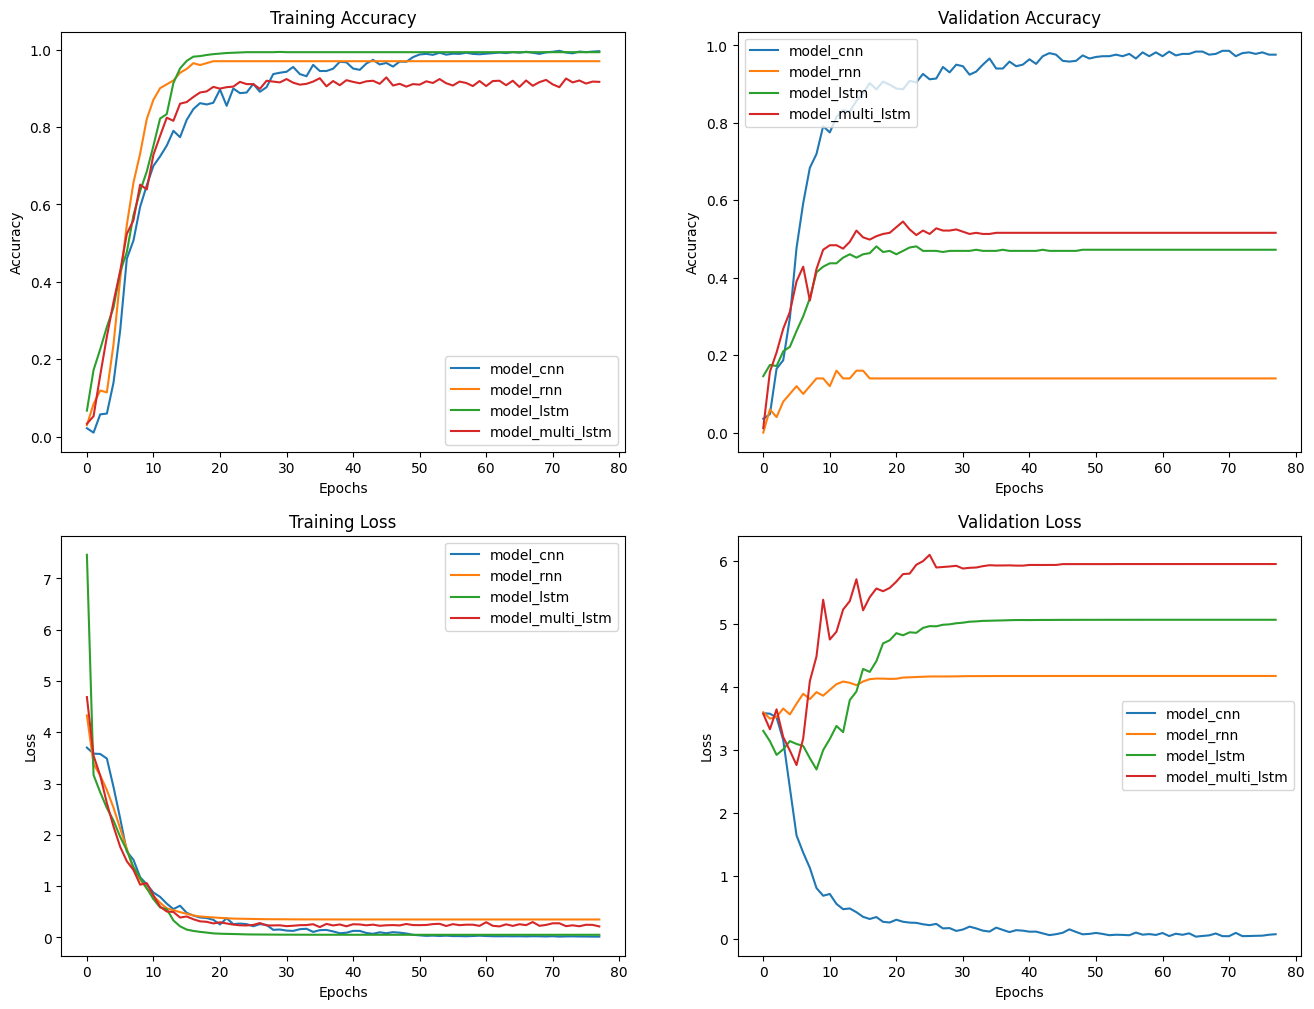

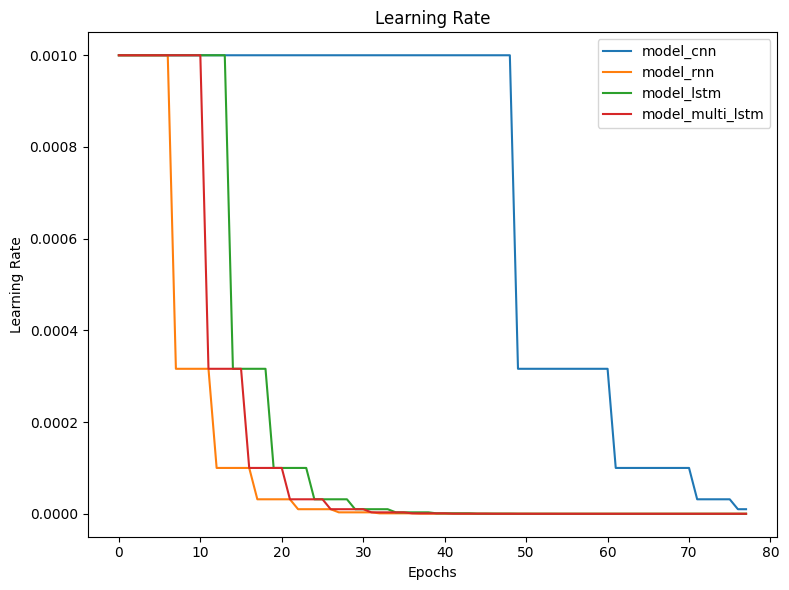

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy over epoch
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(history1['accuracy'], label='model_cnn')
plt.plot(history2['accuracy'], label='model_rnn')
plt.plot(history3['accuracy'], label='model_lstm')
plt.plot(history4['accuracy'], label='model_multi_lstm')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy over epoch
plt.subplot(2, 2, 2)
plt.plot(history1['val_accuracy'], label='model_cnn')
plt.plot(history2['val_accuracy'], label='model_rnn')
plt.plot(history3['val_accuracy'], label='model_lstm')
plt.plot(history4['val_accuracy'], label='model_multi_lstm')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss over epochs
plt.subplot(2, 2, 3)
plt.plot(history1['loss'], label='model_cnn')
plt.plot(history2['loss'], label='model_rnn')
plt.plot(history3['loss'], label='model_lstm')
plt.plot(history4['loss'], label='model_multi_lstm')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss over epochs
plt.subplot(2, 2, 4)
plt.plot(history1['val_loss'], label='model_cnn')
plt.plot(history2['val_loss'], label='model_rnn')
plt.plot(history3['val_loss'], label='model_lstm')
plt.plot(history4['val_loss'], label='model_multi_lstm')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Additional subplot for learning rate
plt.figure(figsize=(8, 6))
plt.plot(history1['lr'], label='model_cnn')
plt.plot(history2['lr'], label='model_rnn')
plt.plot(history3['lr'], label='model_lstm')
plt.plot(history4['lr'], label='model_multi_lstm')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()


**TEST SET PREDICTION**

 - load test data and create test sequences

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def load_data_and_labels_test(directory):
    datagen = ImageDataGenerator(rescale=1./255)
    test_set = datagen.flow_from_directory(
        directory,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle=False  # Do not shuffle test data
    )

    return test_set

def create_sequences_test(data_generator, sequence_length):
    sequences = []
    labels = []

    for _ in range(len(data_generator)):
        batch, label = data_generator.next()
        for i in range(len(batch) - sequence_length + 1):
            sequences.append(batch[i:i + sequence_length])
            labels.append(label[i + sequence_length - 1])

    return np.array(sequences), np.array(labels)

# Load test data and create sequences
sequence_length = 10
test_data_directory = "/content/drive/MyDrive/Colab/data-Splitted/test"
test_data_generator = load_data_and_labels_test(test_data_directory)
test_sequences, test_labels = create_sequences_test(test_data_generator, sequence_length)


Found 503 images belonging to 36 classes.


In [ ]:
print(test_sequences.shape)

(359, 10, 64, 64, 3)


- Reshaping test sequences




In [ ]:
# model expects input shape (10, 64, 64, 3)
expected_input_shape = (10, 64, 64, 3)

# Reshape the sequences
num_sequences, sequence_length, height, width, channels = test_sequences.shape
test_sequences_reshaped = test_sequences.reshape((num_sequences, sequence_length, *expected_input_shape[1:]))

# Display the shape of the reshaped sequences
print(test_sequences_reshaped.shape)


(359, 10, 64, 64, 3)


- Flattening test sequence

In [ ]:
import numpy as np

# original shape is (None, 10, 64, 64, 3)
test_samples, sequence_length, height, width, channels = test_sequences_reshaped.shape

# Reshape to (None, 10, 64*64*3)
test_sequences_flattened = test_sequences_reshaped.reshape(test_samples, sequence_length, -1)


- Testset prediction results from my models

In [ ]:
# Having test data for each model (test_set for CNN, test_sequences_reshaped for RNN, LSTM, Multi-LSTM)

# CNN prediction
cnn_results = model_cnn.predict(test_set)

# RNN prediction
rnn_results = model_rnn.predict(test_sequences_reshaped)

# LSTM prediction
lstm_results = model_lstm.predict(test_sequences_flattened)

# Multi-LSTM prediction
multi_lstm_results = model_multi_lstm.predict(test_sequences_flattened)


12/12 [==============================] - 3s 189ms/step


**TEST SET PREDICTON VISUALISATION**

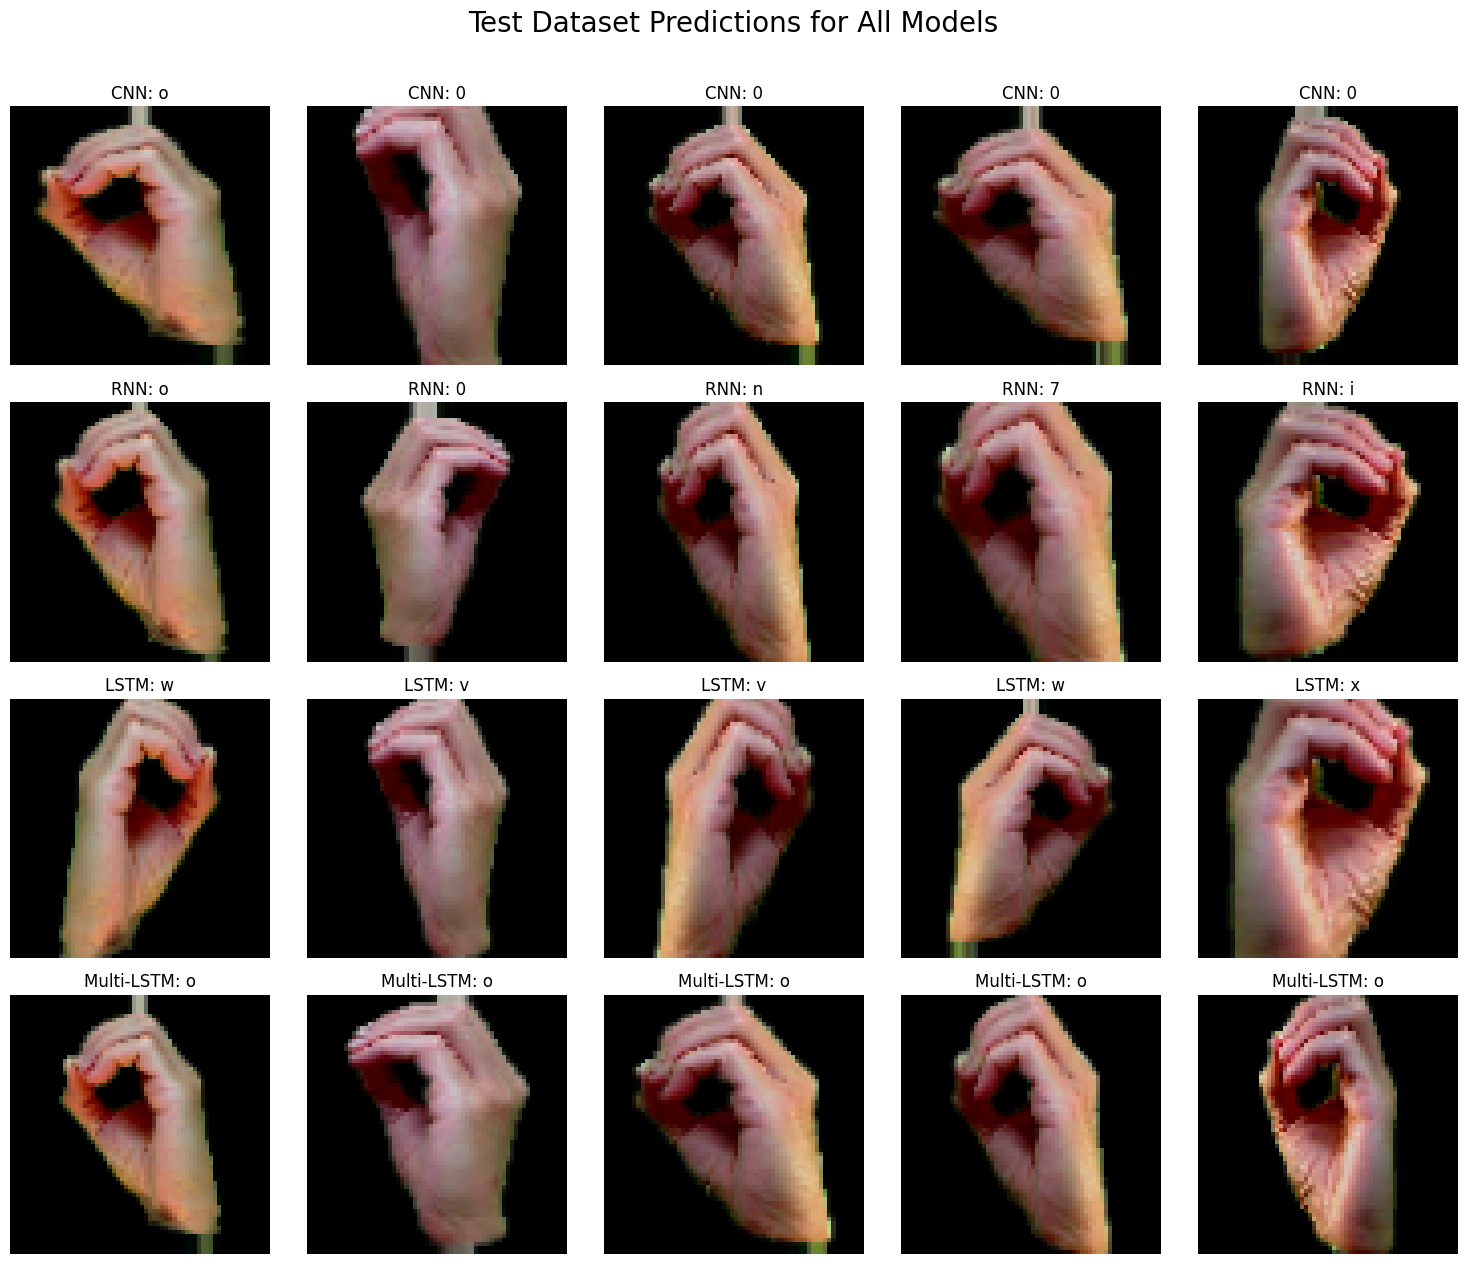

In [ ]:
# Display predictions for all models
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))
models = ["CNN", "RNN", "LSTM", "Multi-LSTM"]
results = [cnn_results, rnn_results, lstm_results, multi_lstm_results]

for i, model_name in enumerate(models):
    for j in range(5):
        predicted_label = labels[np.argmax(results[i][j])]
        axs[i, j].set_title(f"{model_name}: {predicted_label}")
        axs[i, j].imshow(test_set[0][0][j])
        axs[i, j].axis("off")

plt.tight_layout()
plt.suptitle("Test Dataset Predictions for All Models", fontsize=20, y=1.05)
plt.show()


**WRONG TEST SET PREDICTIONS**

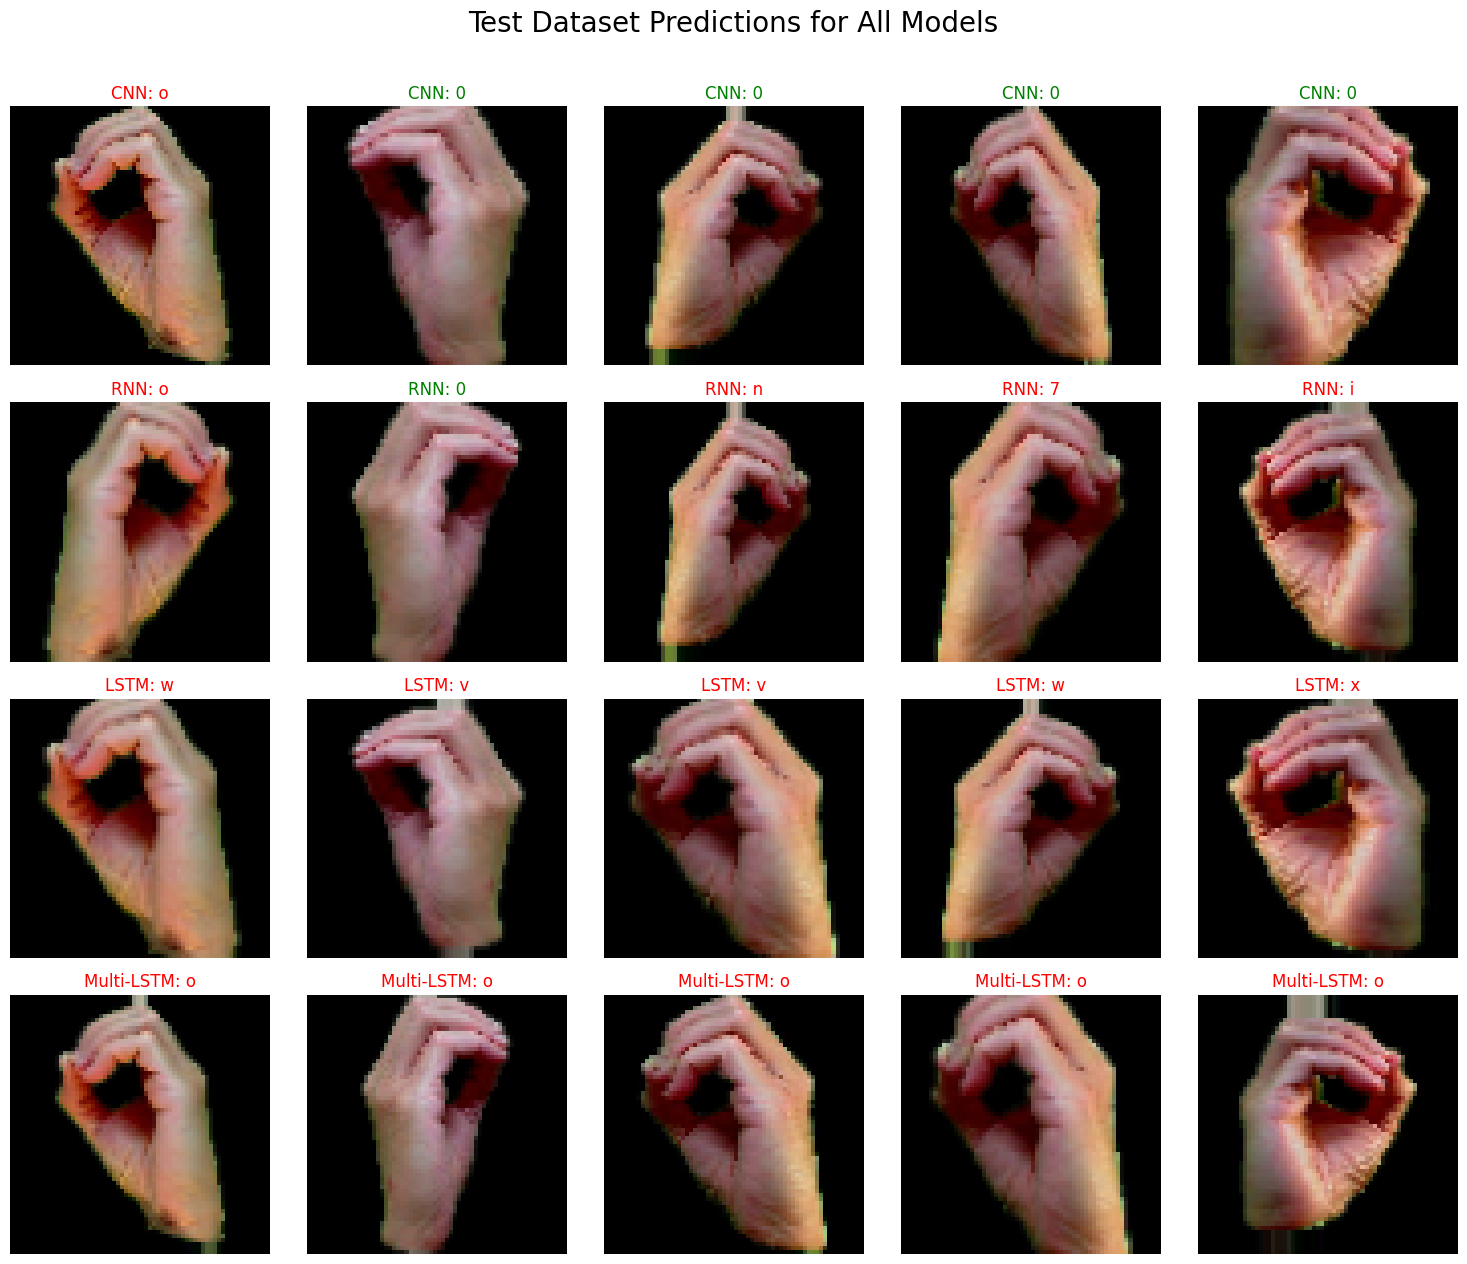

In [ ]:
# Display predictions for all models
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15, 12))
models = ["CNN", "RNN", "LSTM", "Multi-LSTM"]
results = [cnn_results, rnn_results, lstm_results, multi_lstm_results]

for i, model_name in enumerate(models):
    for j in range(5):
        predicted_label = labels[np.argmax(results[i][j])]
        true_label = labels[np.argmax(test_labels[j])]

        # Check if the prediction is correct
        prediction_correct = predicted_label == true_label

        # Set the title and color based on correctness
        title = f"{model_name}: {predicted_label}"
        color = 'green' if prediction_correct else 'red'

        axs[i, j].set_title(title, color=color)
        axs[i, j].imshow(test_set[0][0][j])
        axs[i, j].axis("off")

plt.tight_layout()
plt.suptitle("Test Dataset Predictions for All Models", fontsize=20, y=1.05)
plt.show()


**Model Evaluation**

In [ ]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score

# Assuming your saved models are named model_cnn.h5, model_rnn.h5, model_lstm.h5, model_multi_lstm.h5
model_cnn = load_model('/content/drive/MyDrive/Colab/Models/model_cnn.h5')
model_rnn = load_model('/content/drive/MyDrive/Colab/Models/model_rnn.h5')
model_lstm = load_model('/content/drive/MyDrive/Colab/Models/model_lstm.h5')
model_multi_lstm = load_model('/content/drive/MyDrive/Colab/Models/model_multi_lstm.h5')

# Using loaded and preprocessed test data
# test_set, test_sequences_reshaped, test_sequences_flattened, labels

# Evaluate each model
cnn_results = model_cnn.evaluate(test_set)
rnn_results = model_rnn.evaluate(test_sequences_reshaped, test_labels)
lstm_results = model_lstm.evaluate(test_sequences_flattened, test_labels)
multi_lstm_results = model_multi_lstm.evaluate(test_sequences_flattened, test_labels)

# Extract relevant metrics
cnn_accuracy = cnn_results[1]
rnn_accuracy = rnn_results[1]
lstm_accuracy = lstm_results[1]
multi_lstm_accuracy = multi_lstm_results[1]

# Print the accuracy values
print(f'CNN Accuracy: {cnn_accuracy}')
print(f'RNN Accuracy: {rnn_accuracy}')
print(f'LSTM Accuracy: {lstm_accuracy}')
print(f'Multi-LSTM Accuracy: {multi_lstm_accuracy}')


12/12 [==============================] - 2s 120ms/step - loss: 5.0396 - accuracy: 0.5487
CNN Accuracy: 0.9761431217193604
RNN Accuracy: 0.24791085720062256
LSTM Accuracy: 0.35654595494270325
Multi-LSTM Accuracy: 0.5487465262413025


**PERFORMANCE VISUALISATION**

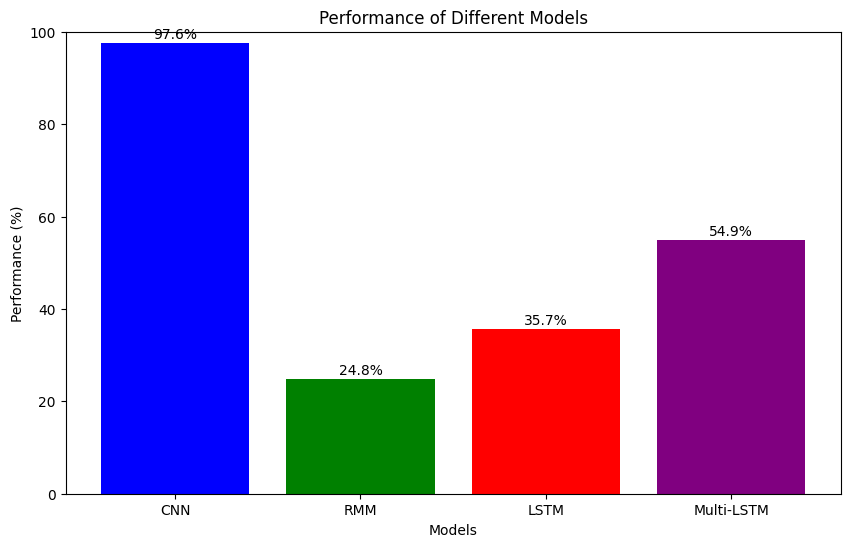

In [ ]:
# Values
cnn = cnn_accuracy
rmm = rnn_accuracy
lstm = lstm_accuracy
multi_lstm = multi_lstm_accuracy

# Data for plotting
models = ['CNN', 'RMM', 'LSTM', 'Multi-LSTM']
values = [cnn * 100, rmm * 100, lstm * 100, multi_lstm * 100]  # Multiply by 100 to convert to percentage

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Performance (%)')
plt.title('Performance of Different Models')
plt.ylim(0, 100)  # Setting the limit for y-axis to 100%

# Adding the text labels on the bars
for i in range(len(values)):
    plt.text(i, values[i] + 1, f'{values[i]:.1f}%', ha='center')

# Show plot
plt.show()

**SINGLE PREDICTION**

In [ ]:
print(labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
print(len(labels))


36


- **Preprocessing Functions**

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Load the saved models
model_cnn = load_model('/content/drive/MyDrive/Colab/Models/model_cnn.h5')
model_rnn = load_model('/content/drive/MyDrive/Colab/Models/model_rnn.h5')
model_lstm = load_model('/content/drive/MyDrive/Colab/Models/model_lstm.h5')
model_multi_lstm = load_model('/content/drive/MyDrive/Colab/Models/model_multi_lstm.h5')

# Defining the sequence length used during training
sequence_length = 10

# Preprocessing function for Model 2 (RNN)
def preprocess_for_rnn(image_path, sequence_length):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values

    # Since the model is trained on sequences of images,
    # we need to create a dummy sequence with our single image repeated.
    # The sequence length should be the same used in training.
    sequence = np.tile(img_array, (sequence_length, 1, 1, 1))

    # Reshape to the expected input shape of the RNN model: (1, sequence_length, 64, 64, 3)
    # The first dimension is the batch size.
    sequence = sequence.reshape(1, sequence_length, 64, 64, 3)

    return sequence

# Preprocessing function for Model 3 (LSTM)
def preprocess_for_lstm(image_path, sequence_length):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values

    # Flatten the image to create a single vector
    flattened_img = img_array.reshape(-1)

    # Create a dummy sequence by repeating the flattened image
    sequence = np.tile(flattened_img, (sequence_length, 1))

    # Reshape to the expected input shape of the LSTM model: (1, sequence_length, 64*64*3)
    # The first dimension is the batch size.
    sequence = sequence.reshape(1, sequence_length, 64 * 64 * 3)

    return sequence

# Preprocessing function for Model 4 (Multi-LSTM)
def preprocess_for_multi_lstm(image_path, sequence_length):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values

    # Flatten the image to create a single vector
    flattened_img = img_array.reshape(-1)

    # Create a dummy sequence by repeating the flattened image
    sequence = np.tile(flattened_img, (sequence_length, 1))

    # Reshape to the expected input shape of the multi-layer LSTM model: (1, sequence_length, 64*64*3)
    # The first dimension is the batch size.
    sequence = sequence.reshape(1, sequence_length, 64 * 64 * 3)

    return sequence

# Load and preprocess a new image for testing
new_image_path = "/content/drive/MyDrive/Colab/data-Splitted/test/8/hand1_8_dif_seg_1_cropped.jpeg"
new_image = image.load_img(new_image_path, target_size=(64, 64))
new_data = image.img_to_array(new_image) / 255.0  # Normalize pixel values

# Model 1 (CNN)
cnn_prediction = model_cnn.predict(np.expand_dims(new_data, axis=0))
cnn_predicted_class = np.argmax(cnn_prediction)

# Model 2 (RNN)
new_data_rnn = preprocess_for_rnn(new_image_path, sequence_length)
rnn_prediction = model_rnn.predict(new_data_rnn)
rnn_predicted_class = np.argmax(rnn_prediction)

# Model 3 (LSTM)
new_data_lstm = preprocess_for_lstm(new_image_path, sequence_length)
lstm_prediction = model_lstm.predict(new_data_lstm)
lstm_predicted_class = np.argmax(lstm_prediction)

# Model 4 (Multi-LSTM)
new_data_multi_lstm = preprocess_for_multi_lstm(new_image_path, sequence_length)
multi_lstm_prediction = model_multi_lstm.predict(new_data_multi_lstm)
multi_lstm_predicted_class = np.argmax(multi_lstm_prediction)

print(f"The class name with CNN model is {cnn_predicted_class} with label: {labels[cnn_predicted_class]}")
print(f"The class name with RNN model is {rnn_predicted_class} with label: {labels[rnn_predicted_class]}")
print(f"The class name with LSTM model is {lstm_predicted_class} with label: {labels[lstm_predicted_class]}")
print(f"The class name with MULTI_LSTM model is {multi_lstm_predicted_class} with label: {labels[multi_lstm_predicted_class]}")


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 355ms/step
The class name with CNN model is 8 with label: 8
The class name with RNN model is 20 with label: k
The class name with LSTM model is 33 with label: x
The class name with MULTI_LSTM model is 8 with label: 8


**CONFUSION MATRIX**

- FOR CNN

Classification Report for CNN Model:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        14
           1       1.00      1.00      1.00        14
           2       1.00      0.93      0.96        14
           3       0.93      1.00      0.97        14
           4       1.00      0.86      0.92        14
           5       0.88      1.00      0.93        14
           6       0.93      0.93      0.93        14
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        14
          10       0.93      1.00      0.97        14
          11       1.00      1.00      1.00        14
          12       1.00      0.93      0.96        14
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        14
          16       0.93      1.00      0.97 

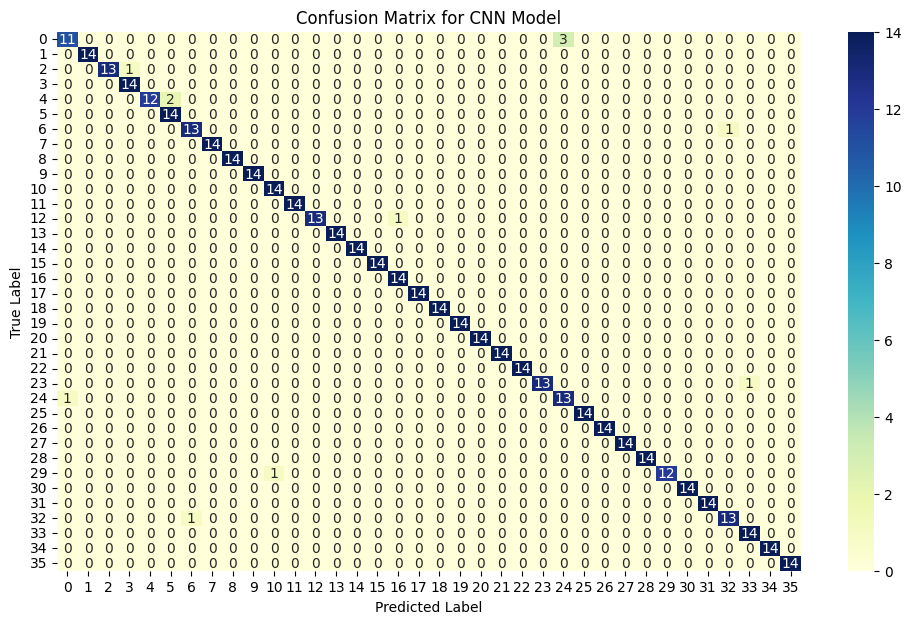

In [ ]:
from sklearn.metrics import classification_report

# Predict labels for the entire test set
predicted_labels_cnn = []
for i in range(len(test_set)):
    X_test, _ = test_set[i]

    # Set verbose parameter
    predictions = model_cnn.predict(X_test, verbose=0)

    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels_cnn.extend(predicted_classes)

# Extract true labels from the test set
true_labels = test_set.classes

# If the test set is very large, adjust the loop above to not exceed the number of batches
# Or use the following to truncate the predicted labels to match the size of true labels
predicted_labels_cnn = predicted_labels_cnn[:len(true_labels)]

# true_labels are the actual labels of your test data
# predicted_labels_cnn are the labels predicted by the CNN model for the test data
conf_matrix_cnn = confusion_matrix(true_labels, predicted_labels_cnn)

# Print the classification report
print("Classification Report for CNN Model:")
print(classification_report(true_labels, predicted_labels_cnn))

# Plotting the confusion matrix
plt.figure(figsize=(12, 7))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Confusion Matrix for CNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


- FOR RNN

Classification Report for RNN Model:
              precision    recall  f1-score   support

           0       0.14      0.21      0.17        14
           1       0.06      0.07      0.06        14
           2       0.06      0.07      0.07        14
           3       1.00      0.00      0.00        14
           4       0.25      0.29      0.27        14
           5       0.00      0.00      0.00        14
           6       0.50      0.14      0.22        14
           7       0.14      0.21      0.17        14
           8       0.29      0.14      0.19        14
           9       0.67      0.14      0.24        14
          10       0.00      0.00      0.00        14
          11       0.75      0.21      0.33        14
          12       0.00      0.00      0.00        14
          13       0.12      0.07      0.09        14
          14       0.60      0.21      0.32        14
          15       0.12      0.14      0.13        14
          16       0.50      0.43      0.46 

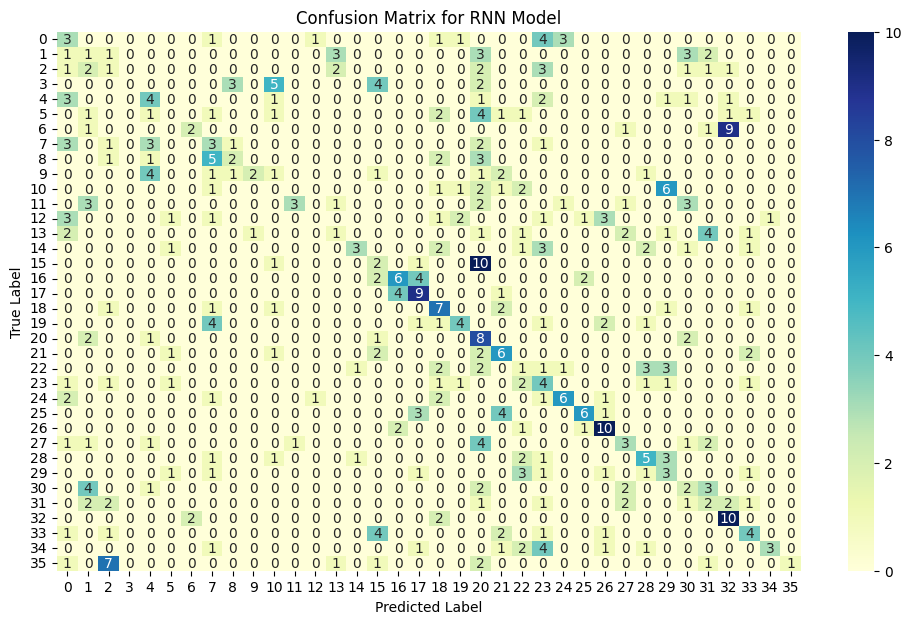

In [ ]:
import tempfile
from sklearn.metrics import classification_report

predicted_labels_rnn = []

for i in range(len(test_set)):
    X_test, _ = test_set[i]
    for img_array in X_test:
        # Save the image array to a temporary file
        with tempfile.NamedTemporaryFile(delete=True, suffix='.jpeg') as temp_image:
            image.save_img(temp_image.name, image.array_to_img(img_array * 255.0))  # Denormalize before saving
            # Preprocess the image for RNN
            sequence = preprocess_for_rnn(temp_image.name, sequence_length)
            # Predict the label with verbose=0
            prediction = model_rnn.predict(sequence, verbose=0)
            predicted_class = np.argmax(prediction)
            predicted_labels_rnn.append(predicted_class)

true_labels = test_set.classes
predicted_labels_rnn = predicted_labels_rnn[:len(true_labels)]

conf_matrix_rnn = confusion_matrix(true_labels, predicted_labels_rnn)

# Print the classification report with zero_division parameter set to 1
print("Classification Report for RNN Model:")
print(classification_report(true_labels, predicted_labels_rnn, zero_division=1))

# Plotting the confusion matrix
plt.figure(figsize=(12, 7))
sns.heatmap(conf_matrix_rnn, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Confusion Matrix for RNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


- FOR LSTM

Classification Report for LSTM Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      0.50      0.44        14
           2       0.38      0.21      0.27        14
           3       0.00      0.00      0.00        14
           4       0.20      0.14      0.17        14
           5       0.38      0.21      0.27        14
           6       0.36      0.29      0.32        14
           7       0.25      0.14      0.18        14
           8       0.60      0.21      0.32        14
           9       0.33      0.29      0.31        14
          10       0.40      0.14      0.21        14
          11       0.27      0.71      0.39        14
          12       0.62      0.36      0.45        14
          13       0.29      0.14      0.19        14
          14       0.20      0.21      0.21        14
          15       0.20      0.21      0.21        14
          16       0.30      0.21      0.25

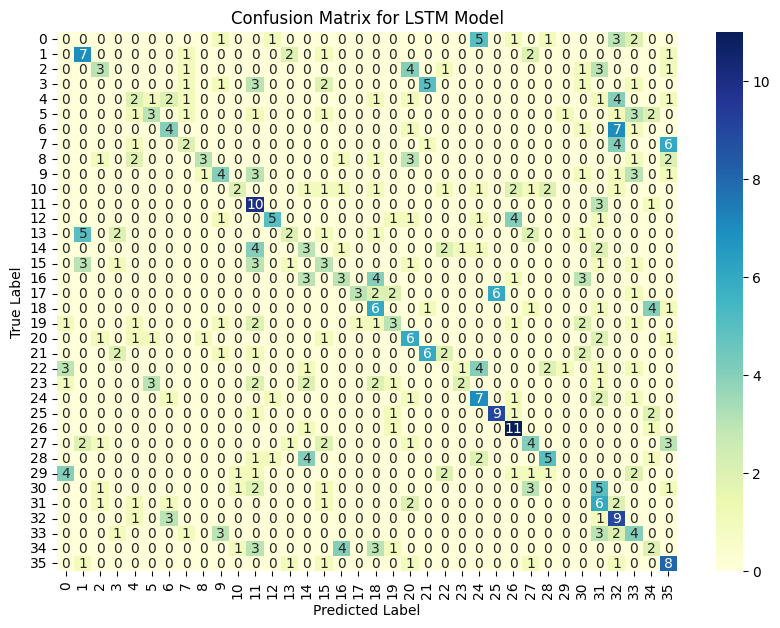

In [ ]:
import tempfile
from sklearn.metrics import classification_report

predicted_labels_lstm = []

for i in range(len(test_set)):
    X_test, _ = test_set[i]
    for img_array in X_test:
        # Save the image array to a temporary file
        with tempfile.NamedTemporaryFile(delete=True, suffix='.jpeg') as temp_image:
            image.save_img(temp_image.name, image.array_to_img(img_array * 255.0))  # Denormalize before saving
            # Preprocess the image for LSTM
            sequence = preprocess_for_lstm(temp_image.name, sequence_length)
            # Predict the label with verbose=0
            prediction = model_lstm.predict(sequence, verbose=0)
            predicted_class = np.argmax(prediction)
            predicted_labels_lstm.append(predicted_class)

true_labels = test_set.classes
predicted_labels_lstm = predicted_labels_lstm[:len(true_labels)]

conf_matrix_lstm = confusion_matrix(true_labels, predicted_labels_lstm)

# Print the classification report
print("Classification Report for LSTM Model:")
print(classification_report(true_labels, predicted_labels_lstm))

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Confusion Matrix for LSTM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


- FOR MULTI LSTM

Classification Report for Multi LSTM Model:
              precision    recall  f1-score   support

           0       0.29      0.29      0.29        14
           1       0.67      0.43      0.52        14
           2       0.38      0.43      0.40        14
           3       0.38      0.43      0.40        14
           4       0.36      0.29      0.32        14
           5       0.38      0.64      0.47        14
           6       0.25      0.21      0.23        14
           7       0.44      0.29      0.35        14
           8       0.50      0.21      0.30        14
           9       0.33      0.43      0.38        14
          10       0.37      0.50      0.42        14
          11       0.71      0.71      0.71        14
          12       0.56      0.36      0.43        14
          13       0.75      0.21      0.33        14
          14       1.00      0.21      0.35        14
          15       0.46      0.43      0.44        14
          16       0.71      0.36    

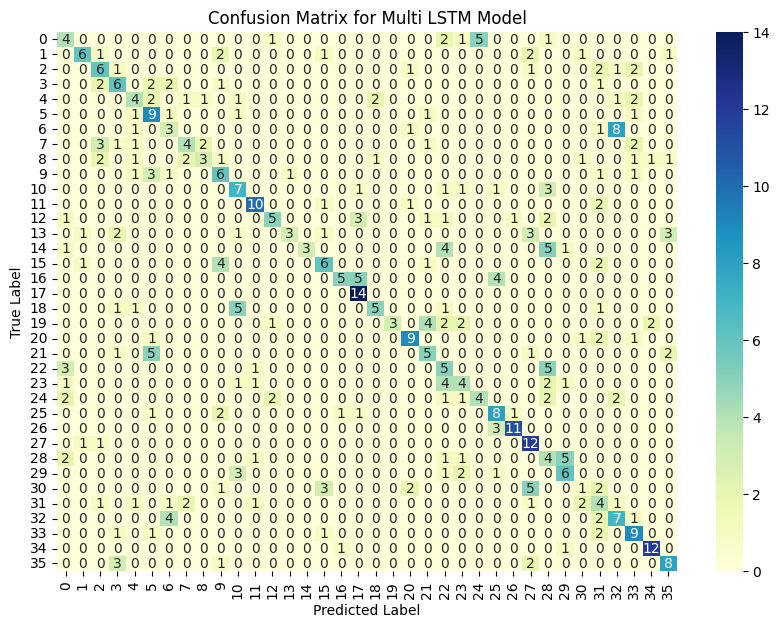

In [ ]:
import tempfile
from sklearn.metrics import classification_report

predicted_labels_multi_lstm = []

for i in range(len(test_set)):
    X_test, _ = test_set[i]
    for img_array in X_test:
        # Save the image array to a temporary file
        with tempfile.NamedTemporaryFile(delete=True, suffix='.jpeg') as temp_image:
            image.save_img(temp_image.name, image.array_to_img(img_array * 255.0))  # Denormalize before saving
            # Preprocess the image for LSTM
            sequence = preprocess_for_multi_lstm(temp_image.name, sequence_length)
            # Predict the label with verbose=0
            prediction = model_multi_lstm.predict(sequence, verbose=0)
            predicted_class = np.argmax(prediction)
            predicted_labels_multi_lstm.append(predicted_class)

true_labels = test_set.classes
predicted_labels_multi_lstm = predicted_labels_multi_lstm[:len(true_labels)]

conf_matrix_multi_lstm = confusion_matrix(true_labels, predicted_labels_multi_lstm)

# Print the classification report
print("Classification Report for Multi LSTM Model:")
print(classification_report(true_labels, predicted_labels_multi_lstm))

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_multi_lstm, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Confusion Matrix for Multi LSTM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
